In [2]:
import pickle
from catboost import CatBoostClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, make_scorer
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBModel, XGBClassifier


##################### Satır ve Sütun Sayıları #####################
(1200, 20)
##################### Nitelik Tipleri #####################
battery           int64
blue              int64
speed           float64
dual_sim          int64
fcamera           int64
g4                int64
memory            int64
pdepth          float64
pweight           int64
cores             int64
pcamera           int64
px_height         int64
px_width          int64
sheight           int64
swidth            int64
talk_time         int64
g3                int64
touch_screen      int64
wifi              int64
price_range       int64
dtype: object
##################### İlk 5 Değer #####################
   battery  blue  speed  dual_sim  fcamera  g4  memory  pdepth  pweight  \
0      842     0    2.2         0        1   0       7     0.6      188   
1     1021     1    0.5         1        0   1      53     0.7      136   
2      563     1    0.5         1        2   1      41     0.9      145   
3      615 

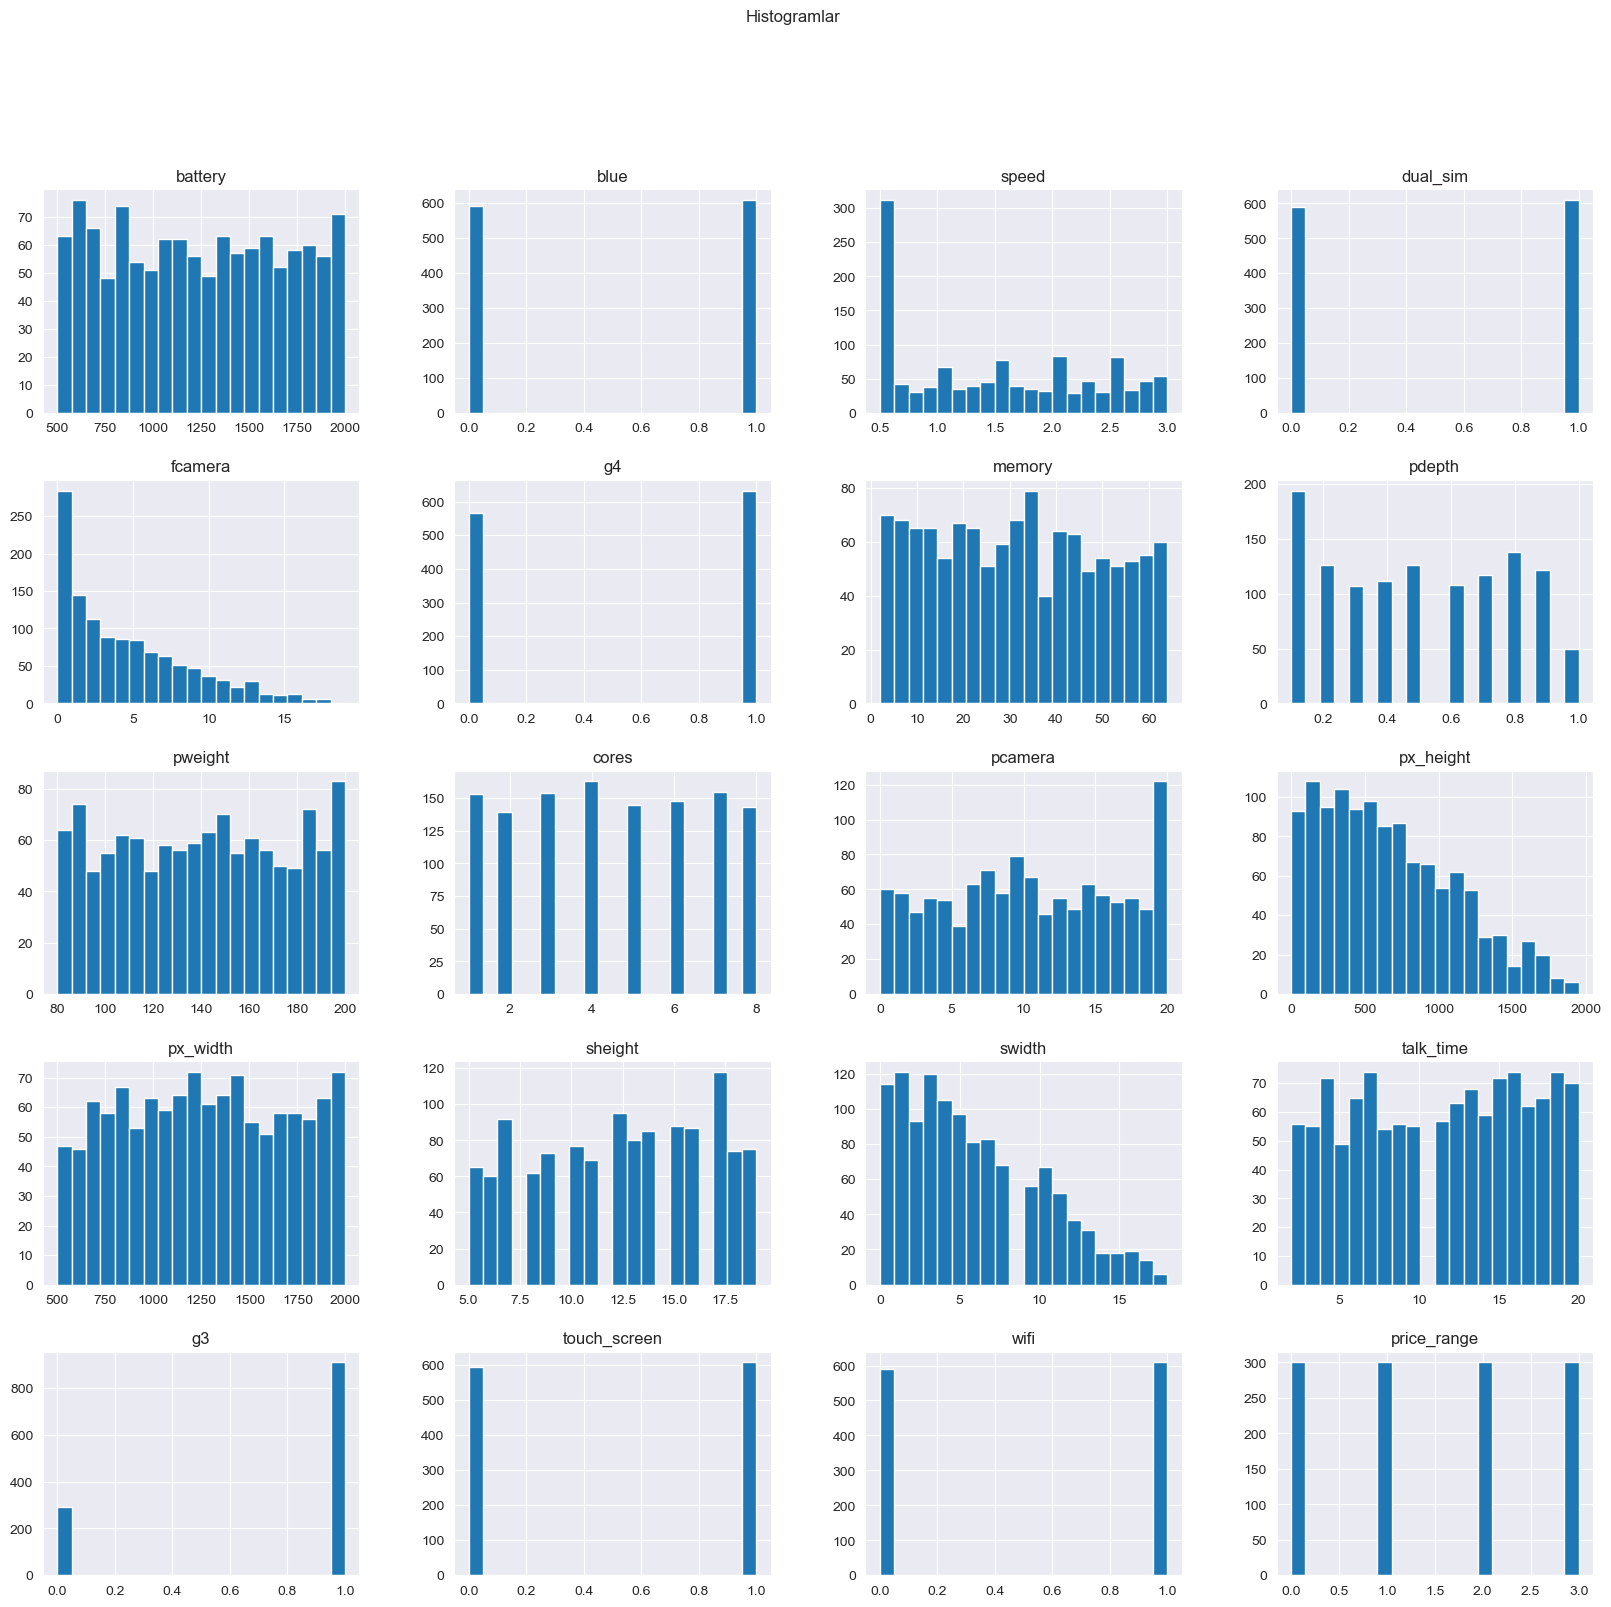

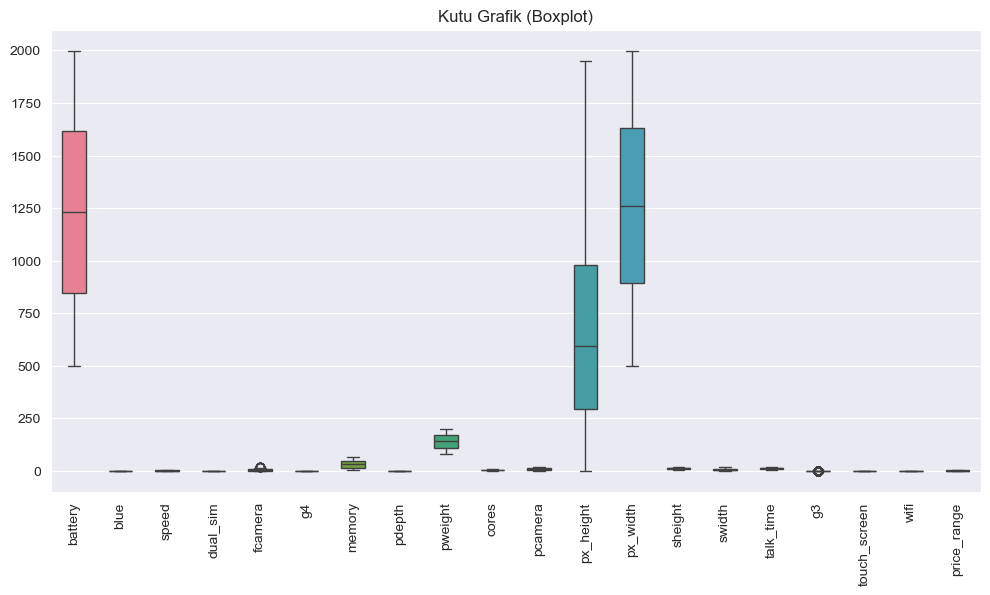

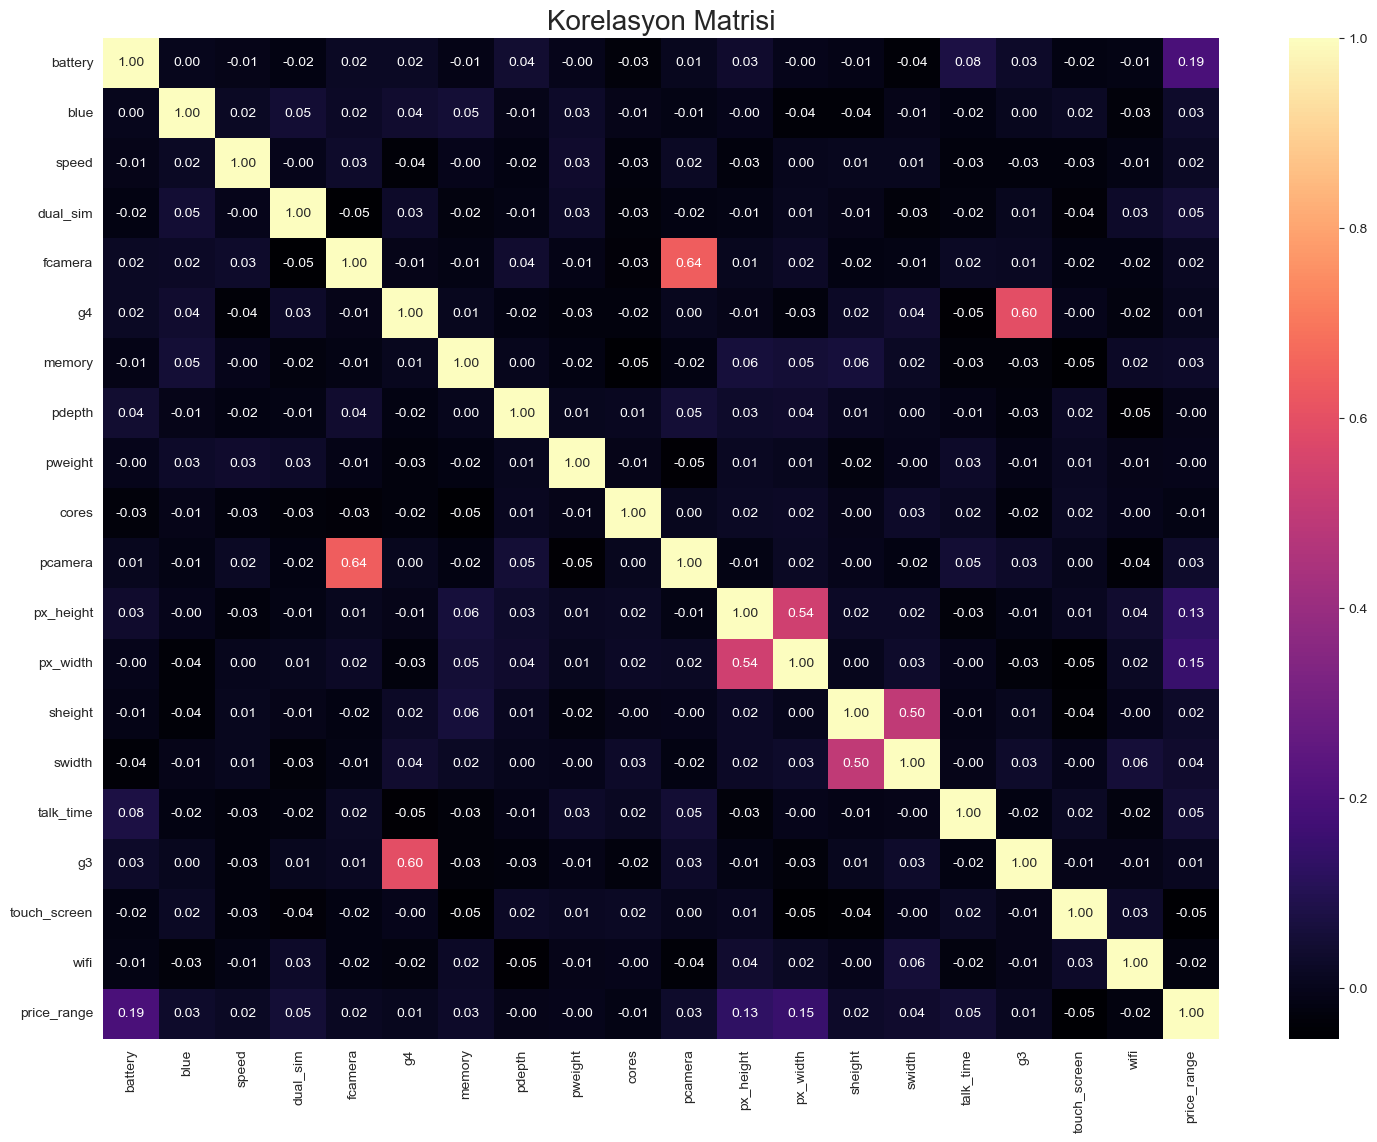

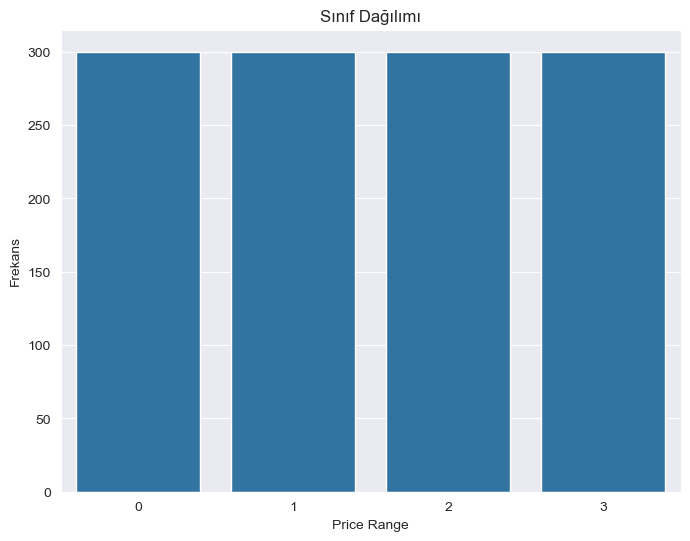

In [3]:

df = pd.read_csv("/Users/rabiagnbs/Desktop/train_odev.csv")
df.head()
def check_df(dataframe, head=5):
    print("##################### Satır ve Sütun Sayıları #####################")
    print(dataframe.shape)
    print("##################### Nitelik Tipleri #####################")
    print(dataframe.dtypes)
    print("##################### İlk 5 Değer #####################")
    print(dataframe.head(head))
    print("##################### Son 5 Değer #####################")
    print(dataframe.tail(head))
    print("##################### Eksik Değerler #####################")
    print(dataframe.isnull().sum())
    print("##################### Aykırı Değerler #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("##################### Ortalama Değerler #####################")
    print(df.mean())
    print("##################### Medyan Değerler #####################")
    print(df.median())
    print("##################### Mod Değerler #####################")
    print(df.mode().iloc[0])
    print("##################### Standart Sapma #####################")
    print(df.std())
    print("##################### Varyans #####################")
    print(df.var())
    print("##################### Beş Sayı Özeti #####################")
    print(df.describe().T)

    df.hist(bins=20, figsize=(20, 18))
    plt.suptitle("Histogramlar")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, width=0.5)
    plt.title("Kutu Grafik (Boxplot)")
    plt.xticks(rotation=90)
    plt.show()

    if 'class' in df.columns:
        sns.pairplot(df, hue='class')
        plt.suptitle("Dağılım Grafiği (Scatter Plot)")
        plt.show()

check_df(df)

correlation_matrix = df.corr()

f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Korelasyon Matrisi", fontsize=20)
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x='price_range', data=df)
plt.title('Sınıf Dağılımı')
plt.xlabel('Price Range')
plt.ylabel('Frekans')
plt.show()

In [4]:
df.isnull().sum()

battery         0
blue            0
speed           0
dual_sim        0
fcamera         0
g4              0
memory          0
pdepth          0
pweight         0
cores           0
pcamera         0
px_height       0
px_width        0
sheight         0
swidth          0
talk_time       0
g3              0
touch_screen    0
wifi            0
price_range     0
dtype: int64

In [5]:
def preprocessing(df, q1=0.25, q3=0.75, n_bins=4):

    def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
        quartile1 = dataframe[col_name].quantile(q1)
        quartile3 = dataframe[col_name].quantile(q3)
        interquantile_range = quartile3 - quartile1
        up_limit = quartile3 + 1.5 * interquantile_range
        low_limit = quartile1 - 1.5 * interquantile_range
        return low_limit, up_limit

    def check_outlier(dataframe, col_name):
        low_limit, up_limit = outlier_thresholds(dataframe, col_name)
        return dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None)

    def replace_with_thresholds(dataframe, variable):
        low_limit, up_limit = outlier_thresholds(dataframe, variable, q1, q3)
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


    for col in df.select_dtypes(include=['int64', 'float64']).columns:  # Yalnızca sayısal sütunları işler
        if check_outlier(df, col):
            print(f"Aykırı değerler '{col}' sütununda bulundu. Eşik değerlerle değiştiriliyor...")
            replace_with_thresholds(df, col)


    print("Tüm sütunlar için aykırı değer işlemleri ve binning işlemi tamamlandı.")
    return df
preprocessing(df)

Aykırı değerler 'fcamera' sütununda bulundu. Eşik değerlerle değiştiriliyor...
Aykırı değerler 'g3' sütununda bulundu. Eşik değerlerle değiştiriliyor...
Tüm sütunlar için aykırı değer işlemleri ve binning işlemi tamamlandı.


,battery,blue,speed,dual_sim,fcamera,g4,memory,pdepth,pweight,cores,pcamera,px_height,px_width,sheight,swidth,talk_time,g3,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,9,7,19,1,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1965,1,2.6,1,0,0,39,0.2,187,4,3,915,1965,11,10,16,1,1,1,2
1196,1911,0,0.9,1,1,1,36,0.7,108,8,3,868,1632,9,1,5,1,1,0,3
1197,1512,0,0.9,0,4,1,46,0.1,145,5,5,336,670,18,10,19,1,1,1,0
1198,510,1,2.0,1,5,1,45,0.9,168,6,16,483,754,19,4,2,1,1,1,3


In [6]:

from sklearn.neighbors import KNeighborsClassifier

df.head()

X = df.drop("price_range", axis=1)
y = df["price_range"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, random_state=17)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

knn_model = KNeighborsClassifier()
knn_model.fit(X_train_res, y_train_res)
y_pred = knn_model.predict(X_test)


print("Doğruluk Skoru:", accuracy_score(y_test, y_pred))
print("Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

cv_results = cross_validate(
    knn_model, X, y, cv=5,
    scoring={"accuracy": "accuracy", "f1": "f1_weighted", "roc_auc": "roc_auc_ovr"}
)

print("Accuracy:", cv_results["test_accuracy"].mean())
print("F1:", cv_results["test_f1"].mean())
print("ROC AUC:", cv_results["test_roc_auc"].mean())


knn_params = {
    'n_neighbors': [5, 7, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
}

knn_best_grid = GridSearchCV(
    estimator=knn_model,
    param_grid=knn_params,
    cv=10, n_jobs=-1, verbose=1,
    scoring="accuracy"
)

knn_best_grid.fit(X_train_res, y_train_res)

print("En İyi Parametreler:", knn_best_grid.best_params_)


knn_final = knn_best_grid.best_estimator_
y_pred = knn_final.predict(X_test)

print("Doğruluk Skoru:", accuracy_score(y_test, y_pred))
print("Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

cv_results = cross_validate(
    knn_final, X, y, cv=5,
    scoring={"accuracy": "accuracy", "f1": "f1_weighted", "roc_auc": "roc_auc_ovr"}
)

print("Accuracy:", cv_results["test_accuracy"].mean())
print("F1:", cv_results["test_f1"].mean())
print("ROC AUC:", cv_results["test_roc_auc"].mean())


NameError: name 'KNeighborsClassifier' is not defined